In [4]:
import numpy as np
import json
from utilities import *
from utilitiesDL import *
from OFDMparam import *
from CFOcorr import *
from getModFeat import *
import random
import os
from glob import glob
from collections import defaultdict

import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
pi = math.pi

In [29]:
imgSizePsk = 15
imgSizeQam = 50
datasetType = 'sim' # {sim, real}
dataType = 'img' # {img, seq}
trainMode = 'test' # {psk, qam, test, single}
coord = 'sph'

SNRVec = np.arange(5, 51, 5, dtype=int)

samplingRate = 20e6
longestPreambleLen = 1200
wlanHTInputSym = 40
wlanHEInputSym = 10
removeNull = True
if trainMode == 'test':
    testFlag = True
else:
    testFlag = False

inputJson = './inputJson/testWifi.json'
classJson = './inputJson/class/testClassWifi.json'

f = open(inputJson)
dataPath = json.load(f)['data_path']
print(dataPath)

fClass = open(classJson)
classJson = json.load(fClass)

protocolList = np.array(classJson['protocolList'])
CPOptList = np.array(classJson['CPOptList'], dtype=object)
CPLenList = np.array(classJson['CPLenList'], dtype=object)
modList = np.array(classJson['modList'], dtype=object)

/project/iarpa/byungjun/cyclo_modul_OFDM/simulation/train/wlanHE/


In [30]:
dataDict = {file:[] for file in protocolList}
for i, protocol in enumerate(protocolList):
    dataDict[protocol] = {file:[] for file in CPOptList[i]}
    for CPOpt in CPOptList[i]:
        dataDict[protocol][CPOpt] = {file:[] for file in modList[i]}
        for mod in modList[i]:
            dataDict[protocol][CPOpt][mod] = {file:[] for file in SNRVec}
            for SNR in SNRVec:
                dataDict[protocol][CPOpt][mod][SNR] = defaultdict(list)

printCount = 0
for subFolder in os.walk(dataPath):
    if datasetType == 'sim':
        dirFilenameList = glob(subFolder[0] + '/*.32cf')
    elif datasetType == 'real':
        dirFilenameList = glob(subFolder[0] + '/*.iq')
    print(subFolder[0].split("/")[-1], len(dirFilenameList), end=' ')
    
    printCount += 1
    if printCount == 5:
        print()
        printCount = 0
        
    if (trainMode == 'qam' and not('qam' in subFolder[0].split("/")[-1])):
        continue

    for fileIndex, dirFileName in enumerate(dirFilenameList):
        fileName = dirFileName.split("/")[-1][:-5]
        fileProtocol = (dirFileName.split("/")[-1][:-5]).split("_")[0]
        fileCPOpt = (dirFileName.split("/")[-1][:-5]).split("_")[1]
        fileMod = int((dirFileName.split("/")[-1][:-5]).split("_")[2])
        fileSNR = int((dirFileName.split("/")[-1][:-5]).split("_")[4])

        fileProtocolIndex = int(np.where(protocolList == fileProtocol)[0])
        if not fileMod in modList[fileProtocolIndex]:
            continue
        fileModIndex = int(np.where(np.array(modList[fileProtocolIndex]) == fileMod)[0])
        if trainMode == 'psk':
            if fileModIndex > 2:
                fileModIndex = 2
        elif trainMode == 'qam':
            fileModIndex -= 2
        # print(fileModIndex, end=' ')
        
        dataDict[fileProtocol][fileCPOpt][fileMod][fileSNR]['label'].append(fileModIndex)
        if datasetType == 'sim':
            load_out = np.fromfile(dirFileName, dtype=np.float32)
            data = load_out[np.arange(0, load_out.shape[0], 2)] +\
                1j * load_out[np.arange(1, load_out.shape[0], 2)]
        elif datasetType == 'real':
            data = np.fromfile(dirFileName, dtype=np.complex64)

        if fileProtocol == 'wlanHT':
            nSubC = 64
            if fileCPOpt == 'Normal':
                CPLen = 8
            else:
                CPLen = 16
            preambleLen = 720
            inputLen = (wlanHTInputSym+2) * (nSubC+CPLen)
            nSym = wlanHTInputSym
        elif fileProtocol == 'wlanHE':
            nSubC = 256
            if fileCPOpt == 'Normal':
                CPLen = 16
                preambleLen = 1152
            elif fileCPOpt == 'Medium':
                CPLen = 32
                preambleLen = 1040
            else:
                CPLen = 64
                preambleLen = 1200  
            inputLen = (wlanHEInputSym+2) * (nSubC+CPLen)
            nSym = wlanHEInputSym

        inputStartIndex = int(random.randint(longestPreambleLen, data.shape[0]-inputLen))
        if datasetType == 'sim':
            firstIndex = (-1 * inputStartIndex + preambleLen) % (nSubC+CPLen)
        elif datasetType == 'real':
            firstIndex = findFirstIndexWifi(data[inputStartIndex : inputStartIndex+inputLen], nSubC, CPLen)
        inputIQ_CFO = corrCFO(data[inputStartIndex : inputStartIndex+inputLen],\
            nSubC, CPLen, firstIndex, samplingRate, 2)
        
        # print('img, ', imgData(feat, imgSize, angleMod).shape)
        if trainMode == 'psk':
            feat = getModFeatWifi(inputIQ_CFO, nSubC, CPLen, firstIndex, nSym, removeNull, False)
            if dataType == 'img':
                dataDict[fileProtocol][fileCPOpt][fileMod][fileSNR]['input'].append(imgData(feat, imgSizePsk, False))
            elif dataType == 'seq':
                feat = np.reshape(feat, (56, 40))
                dataDict[fileProtocol][fileCPOpt][fileMod][fileSNR]['input'].append(sphData(feat))
                
        elif trainMode == 'qam':
            feat = getModFeatWifi(inputIQ_CFO, nSubC, CPLen, firstIndex, nSym, removeNull, True)
            if dataType == 'img':
                dataDict[fileProtocol][fileCPOpt][fileMod][fileSNR]['input'].append(imgData(feat, imgSizeQam, True))
            elif dataType == 'seq':
                feat = np.reshape(feat, (56, 40))
                dataDict[fileProtocol][fileCPOpt][fileMod][fileSNR]['input'].append(sphData(feat))

        elif trainMode == 'test':
            feat = getModFeatWifi(inputIQ_CFO, nSubC, CPLen, firstIndex, nSym, removeNull, False)
            featMod = getModFeatWifi(inputIQ_CFO, nSubC, CPLen, firstIndex, nSym, removeNull, True)
            if dataType == 'img':
                dataDict[fileProtocol][fileCPOpt][fileMod][fileSNR]['input'].append(imgData(feat, imgSizePsk, False)) # watch out this part!!!
                dataDict[fileProtocol][fileCPOpt][fileMod][fileSNR]['inputMod'].append(imgData(featMod, imgSizeQam, True)) #!!!!!!!!!!!!!
            elif dataType == 'seq':
                feat = np.reshape(feat, (56, 40))
                dataDict[fileProtocol][fileCPOpt][fileMod][fileSNR]['input'].append(sphData(feat))

                featMod = np.reshape(featMod, (56, 40))
                dataDict[fileProtocol][fileCPOpt][fileMod][fileSNR]['inputMod'].append(sphData(featMod))
        
        elif trainMode == 'single':
            feat = getModFeatWifi(inputIQ_CFO, nSubC, CPLen, firstIndex, nSym, removeNull, False)
            if dataType == 'img':
                dataDict[fileProtocol][fileCPOpt][fileMod][fileSNR]['input'].append(imgData(feat, imgSizePsk, False)) # watch out this part!!!
            elif dataType == 'seq':
                feat = np.reshape(feat, (56, 40))
                dataDict[fileProtocol][fileCPOpt][fileMod][fileSNR]['input'].append(sphData(feat))

print(' ')
print(' ')
for i, protocol in enumerate(protocolList):
    for CPOpt in CPOptList[i]:
        for mod in modList[i]:
            numFile = 0
            for SNR in SNRVec:
                numFile += len(dataDict[protocol][CPOpt][mod][SNR]['label'])
            print(protocol, CPOpt, str(mod), numFile, end=' ')
        print(' ')

 0 wlanHE_Medium_16qam 800 wlanHE_Medium_64qam 800 wlanHE_Extended_64qam 800 wlanHE_Extended_1024qam 800 
wlanHE_Extended_qpsk 800 wlanHE_Normal_bpsk 800 wlanHE_Medium_1024qam 800 wlanHE_Extended_256qam 800 wlanHE_Normal_1024qam 800 
wlanHE_Medium_qpsk 800 wlanHE_Normal_qpsk 800 wlanHE_Medium_256qam 800 wlanHE_Normal_256qam 800 wlanHE_Normal_16qam 800 
wlanHE_Normal_64qam 800 wlanHE_Medium_bpsk 800 wlanHE_Extended_bpsk 800 wlanHE_Extended_16qam 800  
 
wlanHT Extended 2 0 wlanHT Extended 4 0 wlanHT Extended 16 0 wlanHT Extended 64 0  
wlanHT Normal 2 0 wlanHT Normal 4 0 wlanHT Normal 16 0 wlanHT Normal 64 0  
wlanHE Extended 2 800 wlanHE Extended 4 800 wlanHE Extended 16 800 wlanHE Extended 64 800 wlanHE Extended 256 800 wlanHE Extended 1024 800  
wlanHE Medium 2 800 wlanHE Medium 4 800 wlanHE Medium 16 800 wlanHE Medium 64 800 wlanHE Medium 256 800 wlanHE Medium 1024 800  
wlanHE Normal 2 800 wlanHE Normal 4 800 wlanHE Normal 16 800 wlanHE Normal 64 800 wlanHE Normal 256 800 wlanHE No

-134.4105167121079
222.02986759578806
(50, 50)


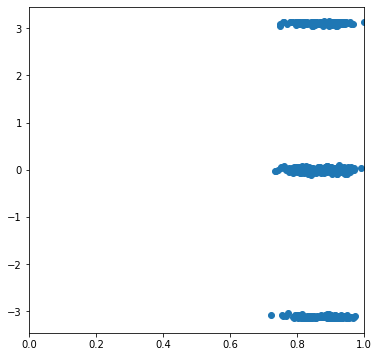

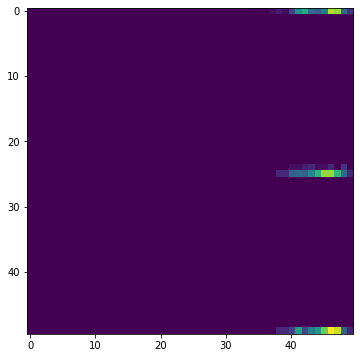

In [7]:
# dataDict['wlanHT']['Extended'][4][30]['input'][0][0, :, :].flatten().shape
# print(feat)
dirFileName = '/project/iarpa/byungjun/cyclo_modul_OFDM/realData/wlanHT/wlanHT_Extended_bpsk/wlanHT_Extended_2_0_30_20_100_1.iq'
dirMetadataFile = open('/project/iarpa/byungjun/cyclo_modul_OFDM/simulation/train/wlanHT/wlanHT_Extended_bpsk/wlanHT_Extended_2_0_30_20_0.4_24.metadata')
loadMetadata = json.load(dirMetadataFile)

# print(dirFileName)
data = np.fromfile(dirFileName, dtype=np.complex64)
# data = load_out[np.arange(0, load_out.shape[0], 2)] +\
#     1j * load_out[np.arange(1, load_out.shape[0], 2)]
# print(data.shape[0])

preambleLen = 1200
nSubC = 64
CPLen = 16
nSym = 10
inputLen = (wlanHEInputSym+2) * (nSubC+CPLen)
inputStartIndex = int(random.randint(longestPreambleLen, data.shape[0]-inputLen))

inputIQ = data[inputStartIndex:inputStartIndex+inputLen]
# firstIndexTruth = (-1 * inputStartIndex + preambleLen) % (nSubC+CPLen)
# print(inputIQ.shape[0], inputStartIndex, firstIndexTruth)
firstIndexEst = findFirstIndexWifi(inputIQ, nSubC, CPLen)

CFOtruth = getCFOtruth(loadMetadata)
print(CFOtruth)
print(estCFO(inputIQ, nSubC, CPLen, firstIndexEst, samplingRate))

inputIQ_CFOest = corrCFO(inputIQ, nSubC, CPLen, firstIndexEst, samplingRate, 2)
feat = getModFeatWifi(inputIQ_CFOest, nSubC, CPLen, firstIndexEst, nSym, removeNull, False)
imgDataResult = np.squeeze(imgData(feat, imgSizeQam, False))
print(imgDataResult.shape)

feat = torch.from_numpy(feat)

plt.figure(figsize=(6,6))
plt.scatter(torch.divide(torch.abs(feat), torch.max(torch.abs(feat))), torch.angle(feat))
plt.xlim(0, 1)

plt.figure(figsize=(6,6))
plt.imshow(imgDataResult)
# print(horIndexIndicator.shape, verIndexIndicator.shape)
# print(np.max(horIndex), np.max(verIndex), np.min(horIndex), np.min(verIndex))
# print(imgInput.shape, absMax)
# xylim = 0.06
# plt.xlim((-xylim, xylim))
# plt.ylim((-xylim, xylim))

seq qam


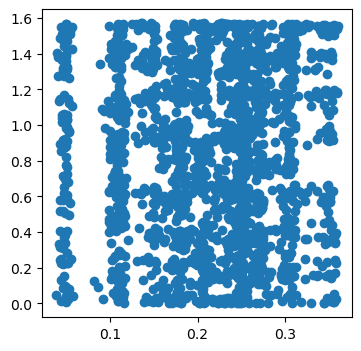

In [57]:
imgDataResult = np.squeeze(dataDict['wlanHE']['Normal'][64][40]['input'][30])
# print(dataDict['wlanHE']['Normal'][16][40]['input'][30].shape)
plt.figure(figsize=(4,4))
# plt.imshow(imgDataResult)
plt.scatter(imgDataResult[0, :, :], imgDataResult[1, :, :])
print(dataType, trainMode)

In [31]:
trList = list()
valList = list()
cudaID = 2
batchSize = 32
SNRThres = 5
trainSNRVec = [SNRThres, SNRThres, SNRThres, SNRThres, SNRThres, SNRThres]

for i, protocol in enumerate(protocolList):
    for CPOpt in CPOptList[i]:
        for iMod, mod in enumerate(modList[i]):
            trDataCount = 0
            valDataCount = 0
            for SNR in SNRVec:
                # dataset = sphDataset(dataDict[protocol][CPOpt][mod][SNR],cuda_id=cudaID)
                dataset = imgDataset(dataDict[protocol][CPOpt][mod][SNR],testFlag,cuda_id=cudaID)

                if iMod >= 10:
                    numTrData = int(np.ceil(0.8*len(dataDict[protocol][CPOpt][mod][SNR]['label']) / 2))
                    numTotData = int(np.ceil(len(dataDict[protocol][CPOpt][mod][SNR]['label'] ) / 2))
                else:
                    numTrData = int(np.ceil(0.8*len(dataDict[protocol][CPOpt][mod][SNR]['label'])))
                    numTotData = len(dataDict[protocol][CPOpt][mod][SNR]['label'])

                if SNR >= trainSNRVec[iMod]:
                    # print(SNR, trainSNRVec[iMod])
                    trList.append(torch.utils.data.Subset(dataset,range(numTrData)))
                    valList.append(torch.utils.data.Subset(dataset,range(numTrData, numTotData)))
                # valDataCount += (numTotData - numTrData)

                if SNR < trainSNRVec[iMod]:
                    numTrData = 0
                    numTotData = 0
                # print(protocol, CPOpt, str(mod), numTrData, numTotData)
                trDataCount += numTrData
                valDataCount += (numTotData - numTrData)

            print(protocol, CPOpt, str(mod), trDataCount, valDataCount)

trDataset = torch.utils.data.ConcatDataset(trList) # concatenating dataset lists
valDataset = torch.utils.data.ConcatDataset(valList)

trLoader = DataLoader(trDataset,batch_size=batchSize,shuffle=True)
valLoader = DataLoader(valDataset,batch_size=batchSize,shuffle=True)

print('Training data size: '+str(len(trDataset))+' Test data size: '+str(len(valDataset)))

wlanHT Extended 2 0 0
wlanHT Extended 4 0 0
wlanHT Extended 16 0 0
wlanHT Extended 64 0 0
wlanHT Normal 2 0 0
wlanHT Normal 4 0 0
wlanHT Normal 16 0 0
wlanHT Normal 64 0 0
wlanHE Extended 2 640 160
wlanHE Extended 4 640 160
wlanHE Extended 16 640 160
wlanHE Extended 64 640 160
wlanHE Extended 256 640 160
wlanHE Extended 1024 640 160
wlanHE Medium 2 640 160
wlanHE Medium 4 640 160
wlanHE Medium 16 640 160
wlanHE Medium 64 640 160
wlanHE Medium 256 640 160
wlanHE Medium 1024 640 160
wlanHE Normal 2 640 160
wlanHE Normal 4 640 160
wlanHE Normal 16 640 160
wlanHE Normal 64 640 160
wlanHE Normal 256 640 160
wlanHE Normal 1024 640 160
NRDLa Extended 4 0 0
NRDLa Extended 16 0 0
NRDLa Extended 64 0 0
NRDLa Extended 256 0 0
NRDLa Normal 4 0 0
NRDLa Normal 16 0 0
NRDLa Normal 64 0 0
NRDLa Normal 256 0 0
NRDLb Normal 4 0 0
NRDLb Normal 16 0 0
NRDLb Normal 64 0 0
NRDLb Normal 256 0 0
NRDLc Normal 4 0 0
NRDLc Normal 16 0 0
NRDLc Normal 64 0 0
NRDLc Normal 256 0 0
Training data size: 11520 Test data

In [16]:
inputSym = 40
LR = 5e-4
criterion = torch.nn.CrossEntropyLoss()

savePskModelPath = './saveDLModel/candidate/wifiHESeqPskReal.cpkt'
saveQamModelPath = './saveDLModel/candidate/wifiHESeqQamReal.cpkt'
saveSingleModelPath = './saveDLModel/candidate/wifiHESeqSingleReal.cpkt'

if trainMode == 'psk':
    if dataType == 'img':
        loadedWifiNet = wifiImgPskNet(3, removeNull)
    elif dataType == 'seq':
        loadedWifiNet = wifiSeqNet(3, removeNull)
elif trainMode == 'qam':
    if dataType == 'img':
        loadedWifiNet = wifiImgQamNet(4, removeNull)
    elif dataType == 'seq':
        loadedWifiNet = wifiSeqNet(4, removeNull)
elif trainMode == 'test':
    if dataType == 'img':
        loadedWifiNet = wifiImgPskNet(6, removeNull)
    elif dataType == 'seq':
        loadedWifiNet = wifiSeqNet(4, removeNull)
elif trainMode == 'single':
    if dataType == 'img':
        loadedWifiNet = wifiImgPskNet(6, removeNull)
    elif dataType == 'seq':
        loadedWifiNet = wifiSeqNet(6, removeNull)
loadedWifiNet.apply(init_weights)

if cudaID is not None: loadedWifiNet = loadedWifiNet.cuda(cudaID)

opt = torch.optim.Adam(loadedWifiNet.parameters(),lr=LR,weight_decay=0.01)
loadedWifiNet.train()   # setting training flag

wifiImgPskNet(
  (conv1): Conv2d(1, 2, kernel_size=(2, 2), stride=(1, 1))
  (conv2): Conv2d(2, 4, kernel_size=(2, 2), stride=(1, 1))
  (conv3): Conv2d(4, 8, kernel_size=(2, 2), stride=(1, 1))
  (conv4): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=16, out_features=1200, bias=True)
  (fc2): Linear(in_features=1200, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=6, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [60]:
accTrainList = []
accValidList = []
bestAcc = 0.0
patience = 0
fastConvergeFlag = True
nEpoch = 150

if trainMode == 'psk':
    saveModelPath = savePskModelPath
elif trainMode == 'qam':
    saveModelPath = saveQamModelPath
elif trainMode == 'test':
    saveModelPath = saveSingleModelPath
elif trainMode == 'single':
    saveModelPath = saveSingleModelPath

print('save model path:', saveModelPath)
torch.set_num_threads(1)
for epoch in range(nEpoch):
    runningLoss = 0.0
    for i, data in enumerate(trLoader):
        # print('train:', i)
        targets = data['target']
        opt.zero_grad()
        trInput = data['input']
        # print(data['input'].shape)

        outputs = loadedWifiNet(trInput)
        loss = criterion(outputs, targets)
        # print('backprop')
        loss.backward()
        opt.step()
        runningLoss += loss.item()

    avgLoss = runningLoss/len(trLoader)
    accTrain = getAcc(trLoader, loadedWifiNet)
    print('epoch: ', epoch, 'train loss: ', round(avgLoss, 4),\
        'accuracy: ', round(accTrain, 4))
    
    # getting valid error
    runningLoss = 0.0
    for i, data in enumerate(valLoader):
        labels = data['target']
        validInput = data['input']

        outputs = loadedWifiNet(validInput)
        valLoss = criterion(outputs, labels)
        runningLoss += valLoss.item()

    avgValLoss = runningLoss/len(valLoader)
    accValid = getAcc(valLoader, loadedWifiNet)
    pred_l,target_l = getPreds(valLoader, loadedWifiNet)

    if bestAcc < accValid:
        bestAcc = accValid
        print('saving model')
        torch.save(loadedWifiNet.state_dict(), saveModelPath)  # saving model with best test accuracy
        patience = 0
        
    print('test loss: ', round(avgValLoss, 4), 'test accuracy:', round(accValid, 4))

    accTrainList.append(accTrain)
    accValidList.append(accValid)
    
    # early stopping if the model converges twice
    patience += 1
    if patience > 20:
        if fastConvergeFlag == True:
            LR = LR/10
            opt = torch.optim.Adam(loadedWifiNet.parameters(),lr=LR,weight_decay=0.01)
            fastConvergeFlag = False
            patience = 0
            print('Fast Converge finishes!')
        else:
            break

print('best test accuracy:', round(bestAcc, 4))

save model path: ./saveDLModel/candidate/wifiHESeqQamReal.cpkt
epoch:  0 train loss:  1.3847 accuracy:  0.2477
saving model
test loss:  1.3584 test accuracy: 0.2483
epoch:  1 train loss:  1.2508 accuracy:  0.3843
saving model
test loss:  1.1754 test accuracy: 0.38
epoch:  2 train loss:  1.1644 accuracy:  0.4176
saving model
test loss:  1.1653 test accuracy: 0.4204
epoch:  3 train loss:  1.1497 accuracy:  0.4305
saving model
test loss:  1.148 test accuracy: 0.43
epoch:  4 train loss:  1.1459 accuracy:  0.382
test loss:  1.213 test accuracy: 0.3825
epoch:  5 train loss:  1.1386 accuracy:  0.432
saving model
test loss:  1.1283 test accuracy: 0.4313
epoch:  6 train loss:  1.1258 accuracy:  0.4195
test loss:  1.1384 test accuracy: 0.4175
epoch:  7 train loss:  1.1256 accuracy:  0.4249
test loss:  1.1319 test accuracy: 0.42
epoch:  8 train loss:  1.118 accuracy:  0.4383
saving model
test loss:  1.095 test accuracy: 0.4425
epoch:  9 train loss:  1.1122 accuracy:  0.4181
test loss:  1.1388 tes

In [24]:
# print(nClass)
cudaID = 2
batchSize = 32
loadedWifiPskNet = wifiImgPskNet(3, removeNull)
loadedWifiQamNet = wifiImgQamNet(4, removeNull)
loadedWifiSingleNet = wifiImgQamNet(6, removeNull)

if cudaID is not None: loadedWifiPskNet = loadedWifiPskNet.cuda(cudaID)
if cudaID is not None: loadedWifiQamNet = loadedWifiQamNet.cuda(cudaID)
if cudaID is not None: loadedWifiSingleNet = loadedWifiSingleNet.cuda(cudaID)   

savePskModelPath = './saveDLModel/candidate/wifiHTImgPsk.cpkt'
saveQamModelPath = './saveDLModel/candidate/wifiHTImgQam.cpkt'
saveSingleModelPath = './saveDLModel/candidate/wifiHTImgSingle.cpkt'

# path for saving model
testSNRVec = range(5, 41, 5)
loadedWifiPskNet.load_state_dict(torch.load(savePskModelPath))
loadedWifiQamNet.load_state_dict(torch.load(saveQamModelPath))
# loadedWifiSingleNet.load_state_dict(torch.load(saveSingleModelPath))

trListCumul = list()
valListCumul = list()
for SNR in testSNRVec:
    trList = list()
    valList = list()

    for i, protocol in enumerate(protocolList):
        for CPOpt in CPOptList[i]:
            for mod in modList[i]:
                dataset = imgDataset(dataDict[protocol][CPOpt][mod][SNR],testFlag,cuda_id=cudaID)
                
                numTrData = int(np.ceil(0.8*len(dataDict[protocol][CPOpt][mod][SNR]['label'])))
                numTotData = len(dataDict[protocol][CPOpt][mod][SNR]['label'])

                # print(protocol, CPOpt, str(mod), numTrData, numTotData)                
                trList.append(torch.utils.data.Subset(dataset,range(numTrData)))
                valList.append(torch.utils.data.Subset(dataset,range(numTrData, numTotData)))

                trListCumul.append(torch.utils.data.Subset(dataset,range(numTrData)))
                valListCumul.append(torch.utils.data.Subset(dataset,range(numTrData, numTotData)))
                
    trDataset = torch.utils.data.ConcatDataset(trList) # concatenating dataset lists
    valDataset = torch.utils.data.ConcatDataset(valList)

    trDatasetCumul = torch.utils.data.ConcatDataset(trListCumul) # concatenating dataset lists
    valDatasetCumul = torch.utils.data.ConcatDataset(valListCumul)

    trLoader = DataLoader(trDataset,batch_size=batchSize,shuffle=True)
    valLoader = DataLoader(valDataset,batch_size=batchSize,shuffle=True)

    trLoaderCumul = DataLoader(trDatasetCumul,batch_size=batchSize,shuffle=True)
    valLoaderCumul = DataLoader(valDatasetCumul,batch_size=batchSize,shuffle=True)

    print(len(trDataset), len(valDataset))
    # accTest = getAcc(valLoader, loadedWifiSingleNet)
    accTest = getAccWifi(valLoader, loadedWifiPskNet, loadedWifiQamNet)

    print(SNR, accTest)

# accTestCumul = getAcc(valLoaderCumul, loadedWifiSingleNet)
accTestCumul = getAccWifi(valLoaderCumul, loadedWifiPskNet, loadedWifiQamNet)
print('cumul:', accTestCumul)

640 160
5 0.725
640 160
10 0.90625
640 160
15 0.9875
640 160
20 1.0
640 160
25 1.0
640 160
30 1.0
640 160
35 1.0
640 160
40 1.0
cumul: 0.95234375


[Text(0, 0, 'BPSK'),
 Text(0, 1, 'QPSK'),
 Text(0, 2, '16QAM'),
 Text(0, 3, '64QAM')]

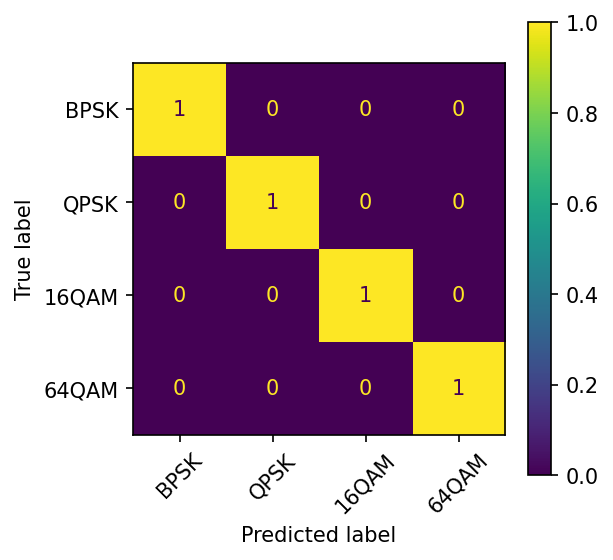

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# pred, target = getPredsWifi(valLoaderCumul, loadedWifiPskNet, loadedWifi16QamNet, loadedWifi64QamNet, loadedWifi256QamNet)
testSNR = 20
valList = list()
for i, protocol in enumerate(protocolList):
    for CPOpt in CPOptList[i]:
        for mod in modList[i]:
            dataset = imgDataset(dataDict[protocol][CPOpt][mod][testSNR],testFlag,cuda_id=cudaID)
            
            numTrData = int(np.ceil(0.8*len(dataDict[protocol][CPOpt][mod][testSNR]['label'])))
            numTotData = len(dataDict[protocol][CPOpt][mod][testSNR]['label'])

            # print(protocol, CPOpt, str(mod), numTrData, numTotData)                
            trList.append(torch.utils.data.Subset(dataset,range(numTrData)))
            valList.append(torch.utils.data.Subset(dataset,range(numTrData, numTotData)))
            
trDataset = torch.utils.data.ConcatDataset(trList) # concatenating dataset lists
valDataset = torch.utils.data.ConcatDataset(valList)

trLoader = DataLoader(trDataset,batch_size=batchSize,shuffle=True)
valLoader = DataLoader(valDataset,batch_size=batchSize,shuffle=True)

pred, target = getPredsWifi(valLoader, loadedWifiPskNet, loadedWifiQamNet)
# pred, target = getPreds(valLoader, loadedWifiSingleNet)

# print(pred, target)
# font = {'size'   : 15}
# plt.rc('font', **font)

cm = confusion_matrix(target,pred,normalize ='true')
for i in range(2):
    for j in range(2):
        cm[i, j] = round(cm[i, j], 2)

# cm[2, 0] = round(cm[2, 0], 2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(4,4), dpi =150)
disp.plot(ax=ax)

# print(modList)
modNameList = []
for mod in modList[1]:        
    if mod == 2:
        # continue
        modul_name = 'BPSK'
    elif mod == 4:
        # continue
        modul_name = 'QPSK'
    elif mod == 16:
        # continue
        modul_name = '16QAM'
    elif mod == 64:
        # break
        # continue
        modul_name = '64QAM'
    elif mod == 256:
        break
        modul_name = '256QAM'
    elif mod == 1024:
        # break
        modul_name = '1024QAM'

    modNameList.append(modul_name)
plt_labels = modNameList
ax.set_xticklabels(plt_labels, rotation=45)
ax.set_yticklabels(plt_labels)

In [29]:
SNRVec = np.arange(40, 41, 2, dtype=int)
FFTsize = 4096
tauVec = np.array([64, 256, 512, 1024, 2048])
CPLenList = [[16, 8], [64, 32, 16], [128, 36], [72], [144]]
CPOptList = np.array([np.array(['Extended', 'Normal']   ),\
    np.array(['Extended', 'Medium', 'Normal']),\
    np.array(['Extended', 'Normal']),\
    np.array(['Normal']), np.array(['Normal'])], dtype=object)
protocolList = np.array(['wlanHT', 'wlanHE', 'NRDLa', 'NRDLb', 'NRDLc'])

In [50]:
load_out = np.fromfile('/project/iarpa/dataset/cyclo_modul_OFDM/simulation/train/wlanHT/wlanHT_Extended_16qam/wlanHT_Extended_16_0_30_20_0.4_2.32cf',\
    dtype=np.float32)
f = open('/project/iarpa/dataset/cyclo_modul_OFDM/simulation/train/wlanHT/wlanHT_Extended_16qam/wlanHT_Extended_16_0_30_20_0.4_2.metadata')
loadMetadata = json.load(f)

data = load_out[np.arange(0, load_out.shape[0], 2)] +\
                    1j * load_out[np.arange(1, load_out.shape[0], 2)]

In [9]:
from torchsummary import summary
summary(loadedWifiNet, input_size=(1, 50, 50))

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.